# Spam Filtering Based on Naive Bayes Classification

In this project, I used one of the widely used statistical spam filters, Bayesian spam filters. Sample emails have two labels are Spam and Ham. Naive Bayes classification will be explained and we will apply this method to our sample emails for testing.

Sample emails:

index| Text                                |  label  |
-----|-------------------------------------|---------|
  0  | gpcm summary this been great yea... |  Ham    |
  1  | national charity suffering since .. |  Spam   |
  :  |   :                                 |    :    |

In [1]:
import wordcloud 
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
import random as rd
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

In [2]:
#Read data
path = "enron2/"
labels = ['Ham','Spam']
Category=[]
textdata = []
a=0
for l in labels:
    for file in os.listdir(path+l):
        Category.append(l)
        with open(os.path.join(path+l,file),encoding='utf8',errors="ignore") as f:
            data = f.read()
            textdata.append(data)
df = pd.DataFrame({"Text" : textdata , "Category":Category})

In [3]:
#Clean non letter characters and words containing three or less letters
df = df.replace("[^a-zA-Z]"," ", regex=True)
for i in range(5):
    df = df.replace("\s(\w{1,3})\s",' ', regex=True)

In [4]:
df.rename(columns = {'Category': 'label', 'Text': 'Email'}, inplace = True)
df['label'] = df['label'].map({'Ham': 0, 'Spam': 1})
df=df.sample(frac=1).reset_index(drop=True)
df.head()

,Email,label
0,Subject houston visit with vince kaminski g...,0
1,Subject prices vince detect hoarding ...,0
2,Subject recruiting carnegie mellon john ...,0
3,Subject ewrm outline vince thanks based ...,0
4,Subject gaming neta prices constraints mcco...,0


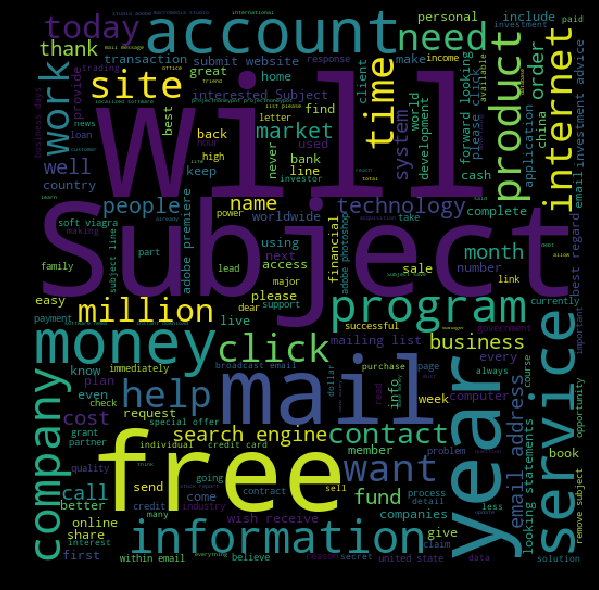

In [5]:
#Graph for Spam Words
spam_words = ' '.join(list(df[df['label'] == 1]['Email']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

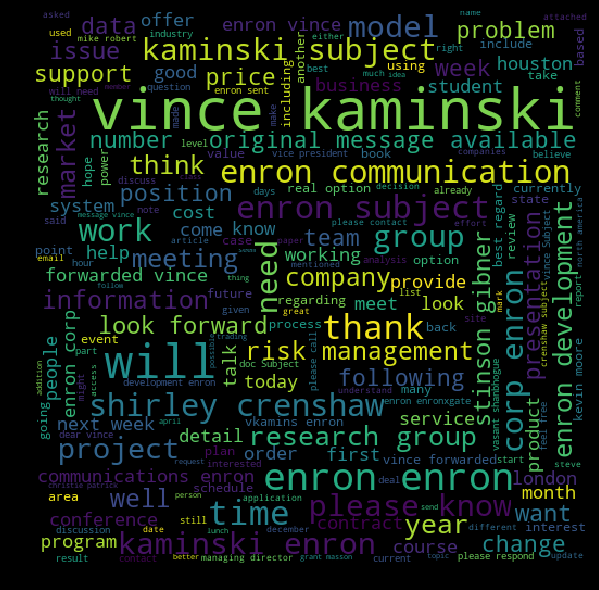

In [6]:
#Graph for Ham Words
spam_words = ' '.join(list(df[df['label'] == 0]['Email']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [7]:
df['Email']=df['Email'].str.lower()
df['words']=df['Email'].str.split()
df.head()

,Email,label,words
0,subject houston visit with vince kaminski g...,0,"[subject, houston, visit, with, vince, kaminsk..."
1,subject prices vince detect hoarding ...,0,"[subject, prices, vince, detect, hoarding, pip..."
2,subject recruiting carnegie mellon john ...,0,"[subject, recruiting, carnegie, mellon, john, ..."
3,subject ewrm outline vince thanks based ...,0,"[subject, ewrm, outline, vince, thanks, based,..."
4,subject gaming neta prices constraints mcco...,0,"[subject, gaming, neta, prices, constraints, m..."


# Split Data to Train and Test

In [8]:
#Split Test and Training
np.random.RandomState(42)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)

In [9]:
train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [10]:
train.head()

,Email,label,words
0,subject energy derivative courses ...,0,"[subject, energy, derivative, courses, forward..."
1,subject executive program credit risk model...,0,"[subject, executive, program, credit, risk, mo..."
2,subject background information electronic...,0,"[subject, background, information, electronic,..."
3,subject energy europe congress floor ...,0,"[subject, energy, europe, congress, floor, bre..."
4,subject eprm article vince wondering th...,0,"[subject, eprm, article, vince, wondering, thi..."


In [11]:
print('Number of Emails')
print ("Train_Spam: {}".format(len(train[train.label==1])))
print ("Train_Ham : {}".format(len(train[train.label==0])))
print ("Test_Spam : {}".format(len(test[test.label==1])))
print ("Test_Ham  : {}".format(len(test[test.label==0])))
print ("Total     : {}".format(len(df)))

Number of Emails
Train_Spam: 1059
Train_Ham : 3040
Test_Spam : 437
Test_Ham  : 1321
Total     : 5857


# Training Data

The following table is made to show the frequency of a token appear
in both email groups, the appearances of each token count only once for
each email received.

In [12]:
WORDS = []
for cell in train.words:
    for word in cell:
        WORDS.append(word)
words=pd.DataFrame(WORDS, columns=['word'])
words['count']=1
Words=words.groupby('word', as_index=False).sum().iloc[:,0:2]
#Words=Words[Words['count']>10]
Words.head()

,word,count
0,a,2
1,aaaenerfax,1
2,aagrawal,1
3,aaldous,3
4,aall,1


In [13]:
Hamwords = []
for cell in train[train.label==0].words:
    for word in cell:
        Hamwords.append(word)
words=pd.DataFrame(Hamwords, columns=['word'])
words['Appearances in Ham']=1
HamWord=words.groupby('word', as_index=False).sum().iloc[:,0:2]
#HamWord=HamWord[HamWord['Appearances in Ham']>10]
HamWord.head()

,word,Appearances in Ham
0,a,1
1,aaaenerfax,1
2,aagrawal,1
3,aaldous,3
4,aaron,5


In [14]:
Spamwords = []
for cell in train[train.label==1].words:
    for word in cell:
        Spamwords.append(word)
words=pd.DataFrame(Spamwords, columns=['word'])
words['Appearances in Spam']=1
SpamWord=words.groupby('word', as_index=False).sum().iloc[:,0:2]
#SpamWord=SpamWord[SpamWord['Appearances in Spam']>10]
SpamWord.head()

,word,Appearances in Spam
0,a,1
1,aall,1
2,aawesome,1
3,abacha,7
4,abaixo,2


In [15]:
merged = pd.merge(Words,HamWord, on='word', how='outer')
Words=pd.merge(merged,SpamWord, on='word', how='outer')
Words=Words.fillna(0)
Words.head()

,word,count,Appearances in Ham,Appearances in Spam
0,a,2,1.0,1.0
1,aaaenerfax,1,1.0,0.0
2,aagrawal,1,1.0,0.0
3,aaldous,3,3.0,0.0
4,aall,1,0.0,1.0


# Filtering Process

Firstly, we break the email we want to classify into a group of individual
words w1, . . . , wn, and denote this email as a capital letter E. The probability
of receiving the email E is equal to the probability of receiving the list
of words w1, . . . , wn.

$$P(E) = P(w_1, . . . , w_n)$$
$$P(E)=\prod_{i=0}^n P(w_i)$$
$$P(E|H) = P(w_1, . . . , w_n|H)$$
$$P(E|H)=\prod_{i=0}^n P(w_i|H)$$


We will calculate the probability of each word for being a spam P(wi|S) (probability of given a email from email class S which it contains the word wi) and ham P(wi|H) (probability of given a email from email class H which it contains the word wi) by using training dataset.

In the following formula, P(wi∩S) is the probability that a given email is a spam email and
contains the word wi. Thus, by Bayes theorem:

$$P(w_i|S)=\frac{P(w_i∩S)}{P(S)}$$

$$P(w_i|H)=\frac{P(w_i∩H)}{P(H)}$$

In [16]:
#We will use Laplace Smoothing 
#This estimation of P(W|H) or P(W|S) could be problematic since it would give us probability 0 for documents with unknown words. 
#A common way of solving this problem is to use Laplace smoothing. add 1/len(unique words)
Words['P(W|H)']=(Words['Appearances in Ham'])/(len(train[train.label==0]))+0.1/Words['count'].sum()
Words['P(W|S)']=(Words['Appearances in Spam'])/(len(train[train.label==1]))+0.1/Words['count'].sum()
#Words['log(P(W|S)/P(W|H))']=np.log(Words['P(W|S)']/Words['P(W|H)'])
Words.head()

,word,count,Appearances in Ham,Appearances in Spam,P(W|H),P(W|S)
0,a,2,1.0,1.0,3.291268e-04,9.444665e-04
1,aaaenerfax,1,1.0,0.0,3.291268e-04,1.794726e-07
2,aagrawal,1,1.0,0.0,3.291268e-04,1.794726e-07
3,aaldous,3,3.0,0.0,9.870216e-04,1.794726e-07
4,aall,1,0.0,1.0,1.794726e-07,9.444665e-04


We will add $log(\frac{P(S)}{P(H)})$ , $log({P(w_i|S)})$ and $log({P(w_i|H)})$ to test data frame as following to find $log(\frac{P(S|E)}{P(H|E)})$. If $log(\frac{P(S|E)}{P(H|E)})>0$ , we classify Email as spam, Similarly,
we classify the email as ham if it is less than zero.

Sample emails:

index| Text                                |  label  |$log\frac{P(S)}{P(H)}$ |logP(w_i/S)      | logP(w_i/H)     |predict_label
-----|-------------------------------------|---------|-----------------------|-----------------------------------
  0  | gpcm summary this been great yea... |  Ham    |     ...               |       ...       |     ...         |
  1  | national charity suffering since .. |  Spam   |      ...              |      ...        |    ...          |
  :  |   :                                 |    :    |

$$Log(\prod_{i=0}^n P(w_i|S))= log(P(w_0|S)+log(P(w_1|S))+log(P(w_2|S))+.....+log(P(w_n|S))$$

$$Log(\prod_{i=0}^n P(w_i|H))= log(P(w_0|H)+log(P(w_1|H))+log(P(w_2|H))+.....+log(P(w_n|H))$$

In [17]:
Y=[]
for i in range (0, len(test)):
    Y.append((pd.DataFrame(test.words[i], columns=['word'])))  

In [18]:
#Z=Y
#for i in range (len(test)):
 #   Z[i]['P(W|H)']=0

In [19]:
#Ham Word Prob
A=[]
for i in range(len(test)):
    A.append([np.array(Words[Words.word==wrds]['P(W|H)']) for wrds in Y[i].word])

In [20]:
ZZ=[]
for i in range (0, len(test)):
    ZZ.append(np.log(pd.DataFrame(A[i]).iloc[1:,]).dropna().sum())

In [21]:
test['log(P(wi|H)']=pd.DataFrame(ZZ)
test.head()

,Email,label,words,log(P(wi|H)
0,subject vince never hurts rarely an...,0,"[subject, vince, never, hurts, rarely, anyway,...",-238.461817
1,subject john martin baylor cindy wharto...,0,"[subject, john, martin, baylor, cindy, wharton...",-209.012817
2,subject argentina power market modelling ...,0,"[subject, argentina, power, market, modelling,...",-939.036729
3,subject risk june boston s...,0,"[subject, risk, june, boston, speaker, confirm...",-232.050104
4,subject proteja negocio cctv alarmas ...,1,"[subject, proteja, negocio, cctv, alarmas, con...",-174.007391


In [22]:
A=[]
for i in range(len(test)):
    A.append([np.array(Words[Words.word==wrd]['P(W|S)']) for wrd in Y[i].word])

In [23]:
ZZ=[]
for i in range (0, len(test)):
    ZZ.append(np.log(pd.DataFrame(A[i]).iloc[1:,]).dropna().sum())

In [24]:
test['log(P(wi|S))']=pd.DataFrame(ZZ)
test.head()

,Email,label,words,log(P(wi|H),log(P(wi|S))
0,subject vince never hurts rarely an...,0,"[subject, vince, never, hurts, rarely, anyway,...",-238.461817,-474.529820
1,subject john martin baylor cindy wharto...,0,"[subject, john, martin, baylor, cindy, wharton...",-209.012817,-535.045445
2,subject argentina power market modelling ...,0,"[subject, argentina, power, market, modelling,...",-939.036729,-2271.930131
3,subject risk june boston s...,0,"[subject, risk, june, boston, speaker, confirm...",-232.050104,-376.655759
4,subject proteja negocio cctv alarmas ...,1,"[subject, proteja, negocio, cctv, alarmas, con...",-174.007391,-109.458860


In [25]:
test['log(P(S)/P(H))']=np.log(len(test[test.label==1])/len(test[test.label==0]))

In [26]:
test['log(P(S|E)/P(H|E))']=test['log(P(wi|S))']-test['log(P(wi|H)']
test.head()

,Email,label,words,log(P(wi|H),log(P(wi|S)),log(P(S)/P(H)),log(P(S|E)/P(H|E))
0,subject vince never hurts rarely an...,0,"[subject, vince, never, hurts, rarely, anyway,...",-238.461817,-474.529820,-1.106211,-236.068003
1,subject john martin baylor cindy wharto...,0,"[subject, john, martin, baylor, cindy, wharton...",-209.012817,-535.045445,-1.106211,-326.032628
2,subject argentina power market modelling ...,0,"[subject, argentina, power, market, modelling,...",-939.036729,-2271.930131,-1.106211,-1332.893402
3,subject risk june boston s...,0,"[subject, risk, june, boston, speaker, confirm...",-232.050104,-376.655759,-1.106211,-144.605655
4,subject proteja negocio cctv alarmas ...,1,"[subject, proteja, negocio, cctv, alarmas, con...",-174.007391,-109.458860,-1.106211,64.548531


In [27]:
label=[]
for i in range (0, len(test)):
        if test['log(P(S|E)/P(H|E))'][i]<0:
            label.append(0)
        else:
            label.append(1)

In [28]:
test['predict_label']=label

In [29]:
from sklearn import metrics
print(metrics.confusion_matrix(test['label'], test['predict_label']))

[[1319    2]
 [  21  416]]


In [30]:
array = confusion_matrix(test['label'], test['predict_label'])
df_cm = pd.DataFrame(array, range(2),range(2))
(df_cm)

,0,1
0,1319,2
1,21,416


Number of Emails
Train_Spam: 1059
Train_Ham : 3040
Test_Spam : 437
Test_Ham  : 1321
Total     : 5857
Accuracy : %98.6917


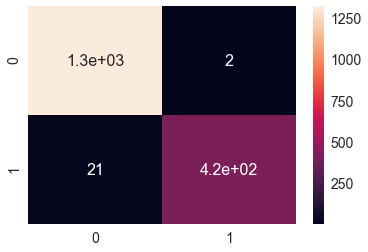

In [32]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(test['label'], test['predict_label'])
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
print('Number of Emails')
print ("Train_Spam: {}".format(len(train[train.label==1])))
print ("Train_Ham : {}".format(len(train[train.label==0])))
print ("Test_Spam : {}".format(len(test[test.label==1])))
print ("Test_Ham  : {}".format(len(test[test.label==0])))
print ("Total     : {}".format(len(df)))
print ("Accuracy : %{:.4f}".format(((array[0][0]+array[1][1])/len(test))*100))